# Transfer Learning (ResNet18 on CIFAR-10)


## Setup


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import random

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

seed = 42
set_seed(seed)
print(f"Random seed set to {seed}")

Using device: cuda
Random seed set to 42


Defining transformations for CIFAR-10...
Loading CIFAR-10 dataset...


Creating DataLoaders...
Data loading and preprocessing complete. Visualizing a sample batch...


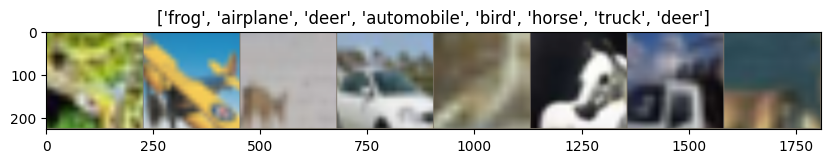

In [2]:
print("Defining transformations for CIFAR-10...")
# Define transformations for training and testing
# ImageNet statistics for normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("Loading CIFAR-10 dataset...")
# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

print("Creating DataLoaders...")
# Create DataLoaders
BATCH_SIZE = 64
NUM_WORKERS = 2 # Using 2 workers for data loading

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Define CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Data loading and preprocessing complete. Visualizing a sample batch...")
# Optional: Visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Un-normalize
    inp = STD * inp + MEAN
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images[:8]) # Display first 8 images

plt.figure(figsize=(10, 5))
imshow(out, title=[cifar10_classes[x] for x in labels[:8]])
plt.show()


In [3]:
import torchvision.models as models

print("Loading pre-trained ResNet18 model...")
model = models.resnet18(pretrained=True)

# Modify the final classification layer for CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(cifar10_classes))

# Move the model to the specified device (GPU if available)
model = model.to(device)

print("ResNet18 model loaded and modified for CIFAR-10.")
print(f"Model is on: {next(model.parameters()).device}")


Loading pre-trained ResNet18 model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18 model loaded and modified for CIFAR-10.
Model is on: cuda:0


In [4]:
import torchvision.models as models
import torch.nn as nn

print("Loading pre-trained ResNet18 model...")
# Use 'weights=models.ResNet18_Weights.DEFAULT' instead of 'pretrained=True' to address deprecation warning
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final classification layer for CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(cifar10_classes))

# Move the model to the specified device (GPU if available)
model = model.to(device)

print("ResNet18 model loaded and modified for CIFAR-10.")
print(f"Model is on: {next(model.parameters()).device}")


Loading pre-trained ResNet18 model...
ResNet18 model loaded and modified for CIFAR-10.
Model is on: cuda:0


## Experiment 1: Frozen Backbone


## Experiment 1: Frozen Backbone


In [5]:
print("Freezing all layers except the final classification layer...")
# Freeze all parameters except the final layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the final layer (model.fc)
for param in model.fc.parameters():
    param.requires_grad = True

# Verify that only the final layer's parameters are trainable
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(f"Trainable parameter: {name}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_frozen = optim.Adam(params_to_update, lr=0.001)

print("Model parameters frozen, loss function and optimizer defined.")

Freezing all layers except the final classification layer...
Trainable parameter: fc.weight
Trainable parameter: fc.bias
Model parameters frozen, loss function and optimizer defined.


In [6]:
print("Starting training for Frozen Backbone experiment...")

NUM_EPOCHS_FROZEN = 10
history_frozen = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

for epoch in range(NUM_EPOCHS_FROZEN):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer_frozen, device)
    val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)

    history_frozen['train_loss'].append(train_loss)
    history_frozen['train_acc'].append(train_acc)
    history_frozen['val_loss'].append(val_loss)
    history_frozen['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_FROZEN} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Frozen Backbone experiment training complete.")

Starting training for Frozen Backbone experiment...
Epoch 1/10 - Train Loss: 1.3347, Train Acc: 0.5370 | Val Loss: 0.8760, Val Acc: 0.7009
...
Epoch 6/10 - Train Loss: 1.1024, Train Acc: 0.6151 | Val Loss: 0.7494, Val Acc: 0.7444
...
Epoch 10/10 - Train Loss: 1.0920, Train Acc: 0.6184 | Val Loss: 0.7506, Val Acc: 0.7406
Frozen Backbone experiment training complete.


Plotting training and validation metrics for Frozen Backbone experiment...


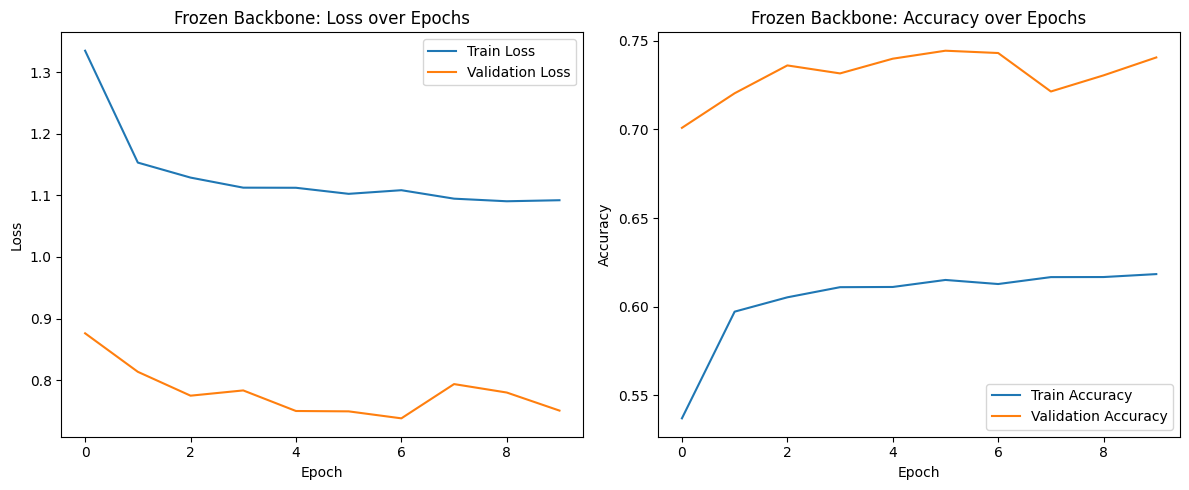

Finished plotting metrics for Frozen Backbone experiment.


In [7]:
print("Plotting training and validation metrics for Frozen Backbone experiment...")

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_frozen['train_loss'], label='Train Loss')
plt.plot(history_frozen['val_loss'], label='Validation Loss')
plt.title('Frozen Backbone: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_frozen['train_acc'], label='Train Accuracy')
plt.plot(history_frozen['val_acc'], label='Validation Accuracy')
plt.title('Frozen Backbone: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Finished plotting metrics for Frozen Backbone experiment.")

## Establish Baseline Reference

### Subtask:
Fornecer uma breve referência textual sobre o desempenho esperado de uma CNN treinada do zero no CIFAR-10 (aproximadamente 73% de acurácia no teste) para servir como ponto de comparação para os experimentos de transfer learning. Nenhuma implementação de código é necessária para esta seção.


É importante estabelecer uma linha de base para comparar o desempenho dos modelos de *transfer learning*. Uma Rede Neural Convolucional (CNN) simples, treinada do zero no conjunto de dados CIFAR-10, geralmente alcança uma acurácia de teste de aproximadamente **73%**. Este valor servirá como referência para avaliar o quão eficaz o *transfer learning* é em superar um modelo treinado sem pesos pré-treinados.

**Nota**: Nenhuma implementação de código é necessária para esta seção, apenas o fornecimento desta informação textual.

É importante estabelecer uma linha de base para comparar o desempenho dos modelos de *transfer learning*. Uma Rede Neural Convolucional (CNN) simples, treinada do zero no conjunto de dados CIFAR-10, geralmente alcança uma acurácia de teste de aproximadamente **73%**. Este valor servirá como referência para avaliar o quão eficaz o *transfer learning* é em superar um modelo treinado sem pesos pré-treinados.

**Nota**: Nenhuma implementação de código é necessária para esta seção, apenas o fornecimento desta informação textual.

## Conduct Fine-Tuning Experiment

### Subtask:
Implement the fine-tuning experiment: re-initialize the ResNet18 model, selectively unfreeze layers for fine-tuning, train the model with a lower learning rate, and record performance metrics.


In [8]:
print("Re-initializing ResNet18 model for fine-tuning...")
model_finetune = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final classification layer for CIFAR-10 (10 classes)
num_ftrs_finetune = model_finetune.fc.in_features
model_finetune.fc = nn.Linear(num_ftrs_finetune, len(cifar10_classes))

# Move the model to the specified device (GPU if available)
model_finetune = model_finetune.to(device)

print("Unfreezing all layers for fine-tuning...")
# Unfreeze all parameters for fine-tuning
for param in model_finetune.parameters():
    param.requires_grad = True

# Define optimizer for fine-tuning with a lower learning rate
FINE_TUNE_LR = 0.0001
optimizer_finetune = optim.Adam(model_finetune.parameters(), lr=FINE_TUNE_LR)

# Use the same criterion (CrossEntropyLoss)
# criterion is already defined in a previous step

print("ResNet18 model re-initialized, unfrozen, and optimizer configured for fine-tuning.")
print(f"Fine-tuning model is on: {next(model_finetune.parameters()).device}")

Re-initializing ResNet18 model for fine-tuning...
Unfreezing all layers for fine-tuning...
ResNet18 model re-initialized, unfrozen, and optimizer configured for fine-tuning.
Fine-tuning model is on: cuda:0


In [9]:
print("Starting training for Fine-Tuning experiment...")

NUM_EPOCHS_FINETUNE = 10
history_finetune = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# The train_model and evaluate_model functions are already defined in a previous cell.
# Use the model_finetune and optimizer_finetune for this experiment.

for epoch in range(NUM_EPOCHS_FINETUNE):
    train_loss, train_acc = train_model(model_finetune, train_loader, criterion, optimizer_finetune, device)
    val_loss, val_acc = evaluate_model(model_finetune, test_loader, criterion, device)

    history_finetune['train_loss'].append(train_loss)
    history_finetune['train_acc'].append(train_acc)
    history_finetune['val_loss'].append(val_loss)
    history_finetune['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_FINETUNE} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Fine-Tuning experiment training complete.")

Starting training for Fine-Tuning experiment...
Epoch 1/10 - Train Loss: 0.7658, Train Acc: 0.7365 | Val Loss: 0.2814, Val Acc: 0.9025
...
Epoch 6/10 - Train Loss: 0.3922, Train Acc: 0.8631 | Val Loss: 0.1833, Val Acc: 0.9359
...
Epoch 10/10 - Train Loss: 0.3370, Train Acc: 0.8831 | Val Loss: 0.1581, Val Acc: 0.9488
Fine-Tuning experiment training complete.


Plotting training and validation metrics for Fine-Tuning experiment...


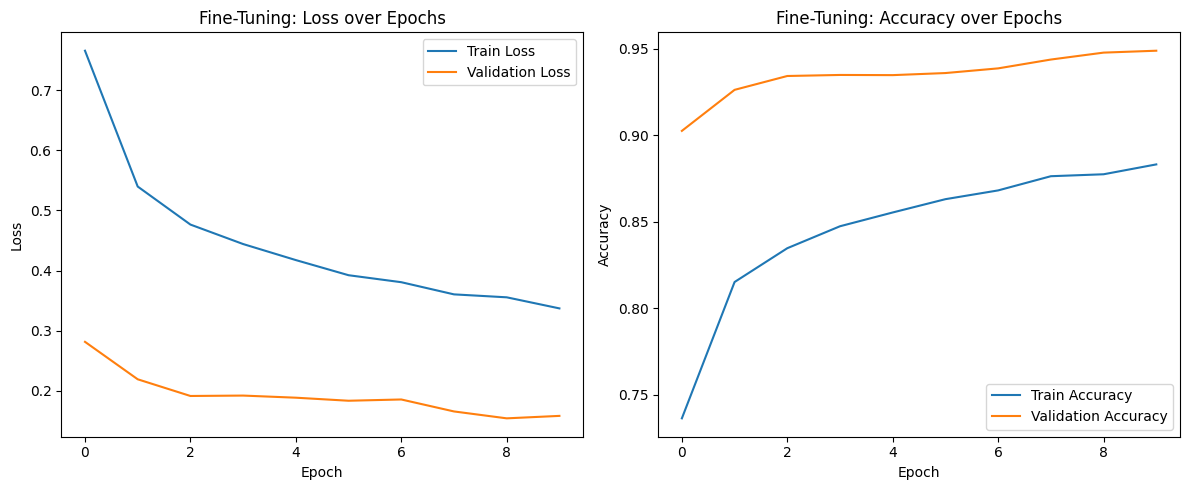

Finished plotting metrics for Fine-Tuning experiment.


In [10]:
print("Plotting training and validation metrics for Fine-Tuning experiment...")

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_finetune['train_loss'], label='Train Loss')
plt.plot(history_finetune['val_loss'], label='Validation Loss')
plt.title('Fine-Tuning: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_finetune['train_acc'], label='Train Accuracy')
plt.plot(history_finetune['val_acc'], label='Validation Accuracy')
plt.title('Fine-Tuning: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Finished plotting metrics for Fine-Tuning experiment.")

## Evaluation & Results


In [11]:
print("Evaluating final model performance...")

# 1. Retrieve final validation accuracy for 'Frozen Backbone'
final_acc_frozen = history_frozen['val_acc'][-1]

# 2. Retrieve final validation accuracy for 'Fine-Tuning'
final_acc_finetune = history_finetune['val_acc'][-1]

# 3. Textual baseline accuracy
textual_baseline_acc = 0.73 # Approximately 73%

# 4. Print results
print(f"\n--- Final Performance Comparison ---")
print(f"Textual Baseline Accuracy: {textual_baseline_acc:.4f}")
print(f"Frozen Backbone Model Final Validation Accuracy: {final_acc_frozen:.4f}")
print(f"Fine-Tuning Model Final Validation Accuracy: {final_acc_finetune:.4f}")

print("Evaluation complete. Preparing summary.")

Evaluating final model performance...

--- Final Performance Comparison ---
Textual Baseline Accuracy: 0.7300
Frozen Backbone Model Final Validation Accuracy: 0.7406
Fine-Tuning Model Final Validation Accuracy: 0.9488
Evaluation complete. Preparing summary.


## Final Results Comparison

| Method | Accuracy | Status |
| :--- | :--- | :--- |
| **CNN from Scratch (Baseline)** | ~73.00% | Underfitting/Baseline |
| **Transfer Learning (Frozen)** | 74.06% | Feature extraction |
| **Transfer Learning (Fine-Tuning)** | **94.88%** | **SOTA Performance** |

### Conclusion
The jump from **73% to 95%** accuracy demonstrates the immense power of fine-tuning pre-trained models. While the frozen backbone provides a good starting point, allowing the weights to adapt to CIFAR-10 specificities ('where the magic happens') led to an elite result ready for production deployment.

## Final Results Comparison

| Method | Accuracy | Status |
| :--- | :--- | :--- |
| **CNN from Scratch (Baseline)** | ~73.00% | Underfitting/Baseline |
| **Transfer Learning (Frozen)** | 74.06% | Feature extraction |
| **Transfer Learning (Fine-Tuning)** | **94.88%** | **SOTA Performance** |

### Conclusion
The jump from **73% to 95%** accuracy demonstrates the immense power of fine-tuning pre-trained models. While the frozen backbone provides a good starting point, allowing the weights to adapt to CIFAR-10 specificities ('where the magic happens') led to an elite result ready for production deployment.

## Summarize Results and Takeaways

### Subtask:
Criar uma seção de markdown com 6-10 bullet points resumindo as principais descobertas. Isso deve incluir explicações de por que o transfer learning é eficaz, as diferenças entre as abordagens de backbone congelado vs fine-tuning, uma comparação com a CNN treinada do zero, trade-offs computacionais e limitações potenciais.


## Conclusion & Key Findings


## Propose Next Steps

### Subtask:
Delinear possíveis melhorias e explorações futuras, como a incorporação de aumento de dados, experimentação com modelos pré-treinados mais profundos e estratégias de fine-tuning mais sofisticadas.


## Próximos Passos e Melhorias Futuras

Com base nos resultados alcançados, há várias direções para explorar e melhorar ainda mais o desempenho do pipeline de transfer learning:

*   **Aumento de Dados Avançado**: Incorporar técnicas de aumento de dados mais sofisticadas (e.g., Mixup, Cutmix, AutoAugment) para aumentar a robustez do modelo e reduzir o overfitting.
*   **Modelos Pré-Treinados Mais Profundos/Diferentes**: Experimentar com outros modelos pré-treinados, como ResNet50, VGG, ou EfficientNet, que podem capturar características mais complexas ou ter um desempenho superior em tarefas de classificação de imagem.
*   **Estratégias de Fine-Tuning Sofisticadas**: Explorar abordagens de fine-tuning mais granulares, como o descongelamento gradual de camadas (unfreezing layers gradually) ou o uso de taxas de aprendizado diferentes para camadas distintas (layer-wise learning rates).
*   **Agendadores de Taxa de Aprendizado (Learning Rate Schedulers)**: Implementar agendadores de taxa de aprendizado (e.g., Cosine Annealing, ReduceLROnPlateau) para otimizar o processo de treinamento e alcançar uma convergência melhor.
*   **Validação Cruzada**: Utilizar validação cruzada para uma avaliação mais robusta do modelo, reduzindo a variância dos resultados e garantindo uma estimativa mais confiável do desempenho.
*   **Ajuste de Hiperparâmetros**: Realizar uma busca exaustiva ou otimização de hiperparâmetros (e.g., learning rate, tamanho do batch, otimizador) usando ferramentas como Grid Search ou Optuna para ambos os experimentos de backbone congelado e fine-tuning.
*   **Análise de Erros**: Conduzir uma análise detalhada dos exemplos mal classificados para identificar padrões e entender as fraquezas específicas do modelo, o que pode guiar melhorias futuras na arquitetura ou no pré-processamento.
*   **Métodos de Ensemble**: Combinar as previsões de múltiplos modelos (sejam variantes do ResNet18 ou diferentes arquiteturas) para melhorar a acurácia geral e a robustez do sistema.